<a href="https://colab.research.google.com/github/Kanika211/Cardiovascular_risk_prediction/blob/main/Cardiovascular_risk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statment**

The dataset is from an ongoing cardiovascular study on residents of the town of Framingham,
Massachusetts. The classification goal is to predict whether the patient has a 10-year risk of
future coronary heart disease (CHD). The dataset provides the patients’ information. It includes
over 4,000 records and 15 attributes. 


Variables
Each attribute is a potential risk factor. There are both demographic, behavioral, and medical risk
factors

## <b>Data Description</b>

<b>Demographic:</b>
• Sex: male or female("M" or "F")

• Age: Age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)

<b>Behavioral</b>

• is_smoking: whether or not the patient is a current smoker ("YES" or "NO")

• Cigs Per Day: the number of cigarettes that the person smoked on average in one day.(can be
considered continuous as one can have any number of cigarettes, even half a cigarette.)

<b>Medical( history)</b>

• BP Meds: whether or not the patient was on blood pressure medication (Nominal)

• Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)

• Prevalent Hyp: whether or not the patient was hypertensive (Nominal)

• Diabetes: whether or not the patient had diabetes (Nominal)
Medical(current)

• Tot Chol: total cholesterol level (Continuous)

• Sys BP: systolic blood pressure (Continuous)

• Dia BP: diastolic blood pressure (Continuous)

• BMI: Body Mass Index (Continuous)

• Heart Rate: heart rate (Continuous - In medical research, variables such as heart rate though in
fact discrete, yet are considered continuous because of large number of possible values.)

• Glucose: glucose level (Continuous)

<b>Predict variable (desired target)</b>

• 10-year risk of coronary heart disease CHD(binary: “1”, means “Yes”, “0” means “No”) -
DV

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import chi2, chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, recall_score, precision_score,\
 accuracy_score, roc_curve, auc, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import Sequential, layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
import warnings

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/data_cardiovascular_risk.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [5]:
df.describe()

,id,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3390.000000,3303.000000,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
mean,1694.500000,49.542183,1.970936,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,978.753033,8.592878,1.019081,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,847.250000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,1694.500000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,2541.750000,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000
max,3389.000000,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


In [6]:
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [7]:
df.tail()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
3385,3385,60,1.0,F,NO,0.0,0.0,0,0,0,261.0,123.5,79.0,29.28,70.0,103.0,0
3386,3386,46,1.0,F,NO,0.0,0.0,0,0,0,199.0,102.0,56.0,21.96,80.0,84.0,0
3387,3387,44,3.0,M,YES,3.0,0.0,0,1,0,352.0,164.0,119.0,28.92,73.0,72.0,1
3388,3388,60,1.0,M,NO,0.0,NaN,0,1,0,191.0,167.0,105.0,23.01,80.0,85.0,0
3389,3389,54,3.0,F,NO,0.0,0.0,0,0,0,288.0,124.0,77.0,29.88,79.0,92.0,0


In [8]:
# lets check for distribution of classes
class_0_count, class_1_count = df[df['TenYearCHD']==0].shape[0], df[df['TenYearCHD']==1].shape[0]
print('Class imbalance = %d: %d' % (class_0_count, class_1_count)) # need to address this after some EDA

Class imbalance = 2879: 511


There are 17 columns in the dataset. Out of which 15 are attributes/features, column 0 is the id of each sample, and column 16 is the target variable. Before doing some data cleaning and EDA, lets split our dataset into train and test data.

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['TenYearCHD'], random_state = 1)

In [10]:
train_df.shape

(2712, 17)

In [11]:
test_df.shape

(678, 17)

## <b>Exploratory Data Analysis</b>

### Categorical Variables

In [12]:
cat_features = ['education', 'sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

In [13]:
simp_imputer = SimpleImputer(strategy="most_frequent")
simp_imputer.fit(train_df[cat_features])
train_df[cat_features]= simp_imputer.transform(train_df[cat_features])
test_df[cat_features]= simp_imputer.transform(test_df[cat_features])

### <b>Education</b>

In [14]:
train_df.education.unique()

array([2.0, 3.0, 1.0, 4.0], dtype=object)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

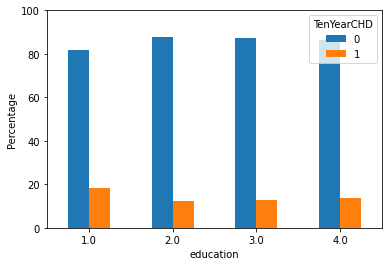

In [15]:
freq_df = train_df.groupby('TenYearCHD')['education'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [16]:
prob = 0.99
alpha = 1.0 - prob

In [17]:
# using chi-square statistic to determine any dependency between categorical variables
def cat_dependency(freq_df, alpha=alpha, verbose=True):
  stat, p, dof, expected = chi2_contingency(freq_df)
  if p <= alpha:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are dependent')
    return True
  else:
    if verbose:
      print('significance=%.3f, p=%.7f' % (alpha, p))
      print('Categorical variables are not dependent')
    return False

In [18]:
cat_dependency(freq_df)

significance=0.010, p=0.0006802
Categorical variables are dependent


True

### <b>Sex</b>

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

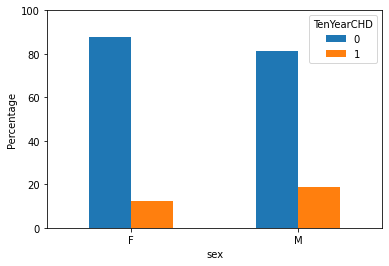

In [19]:
freq_df = train_df.groupby('TenYearCHD')['sex'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [20]:
cat_dependency(freq_df)

significance=0.010, p=0.0000071
Categorical variables are dependent


True

<b>Higher fraction of males are prone to cardiovascular diseases</b>

### <b>Smoking</b>

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

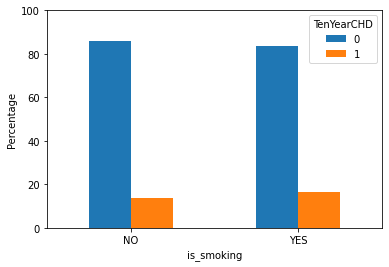

In [21]:
freq_df = train_df.groupby('TenYearCHD')['is_smoking'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [22]:
cat_dependency(freq_df)

significance=0.010, p=0.0928572
Categorical variables are not dependent


False

<b>Statistically smoking has no impact on 10-year risk of CHD</b>

### <b>BP Meds</b>

In [23]:
train_df.BPMeds.unique()

array([0.0, 1.0], dtype=object)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

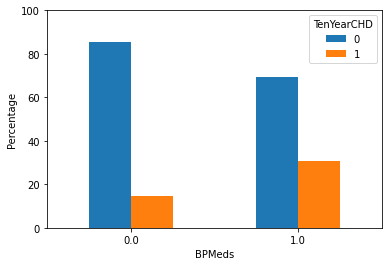

In [24]:
freq_df = train_df.groupby('TenYearCHD')['BPMeds'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [25]:
cat_dependency(freq_df)

significance=0.010, p=0.0001078
Categorical variables are dependent


True

<b>People who take Blood pressure meds have a higher chance of having CHD</b>

### <b>Prevalent Stroke</b>

In [26]:
train_df.prevalentStroke.unique()

array([0, 1], dtype=object)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

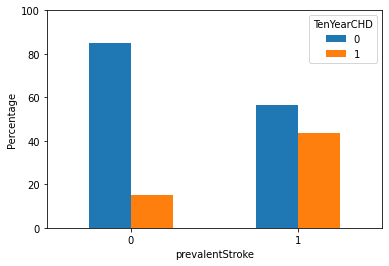

In [27]:
freq_df = train_df.groupby('TenYearCHD')['prevalentStroke'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [28]:
cat_dependency(freq_df)

significance=0.010, p=0.0041885
Categorical variables are dependent


True

<b>Higher percentage of patients with prevalent stroke symptoms have a 10-year risk of CHD</b>

### <b>Prevalent Hypertension</b>

In [29]:
train_df.prevalentHyp.unique()

array([0, 1], dtype=object)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

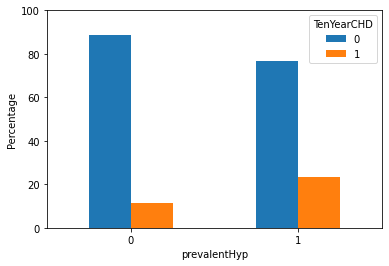

In [30]:
freq_df = train_df.groupby('TenYearCHD')['prevalentHyp'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [31]:
cat_dependency(freq_df)

significance=0.010, p=0.0000000
Categorical variables are dependent


True

<b>Hypertensive patients are at higher risk of CHD</b>

### <b>Diabetes</b>

In [32]:
train_df.diabetes.unique()

array([0, 1], dtype=object)

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

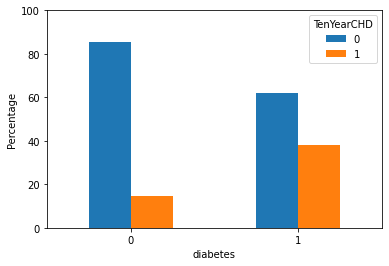

In [33]:
freq_df = train_df.groupby('TenYearCHD')['diabetes'].value_counts().unstack(0)
pct_df = freq_df.divide(freq_df.sum(axis=1), axis=0)*100
pct_df.plot(kind="bar")
plt.ylim(0,100)
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [34]:
cat_dependency(freq_df)

significance=0.010, p=0.0000004
Categorical variables are dependent


True

<b>Diabetic patients tend to have a higher 10-year risk of CHD</b>

## <b>Continuous Variables</b>

In [35]:
cont_features = ['age', 'totChol', 'cigsPerDay', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

In [36]:
knn_imputer= KNNImputer(n_neighbors=5)
knn_imputer.fit(train_df[cont_features])
train_df[cont_features]= knn_imputer.transform(train_df[cont_features])
test_df[cont_features]= knn_imputer.transform(test_df[cont_features])

### <b>Age</b>

In [37]:
train_df.age.unique()

array([49., 51., 57., 59., 52., 60., 48., 40., 54., 39., 56., 44., 42.,
       43., 41., 45., 37., 61., 53., 62., 47., 36., 55., 34., 46., 64.,
       38., 58., 63., 35., 50., 65., 67., 66., 68., 33., 69., 70., 32.])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


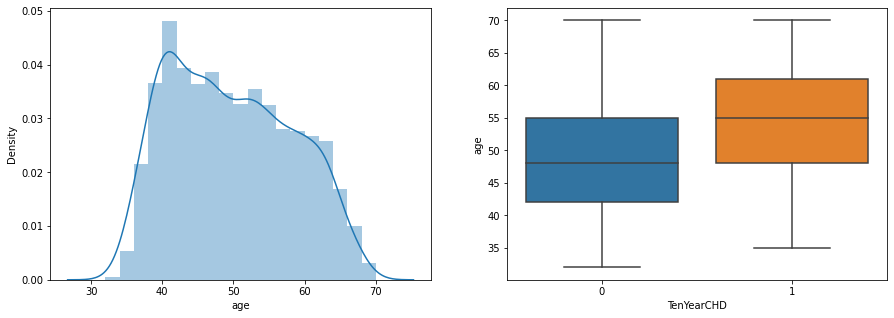

In [38]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['age'], ax=axes[0])
sns.boxplot(y='age',x='TenYearCHD',data=train_df, ax=axes[1])

In [39]:
# using one-way ANOVA test to determine dependency between continuous variables and the target categorical variable
def cont_dependency(feature,alpha=alpha):
  F, p = f_oneway(train_df[train_df['TenYearCHD'] == 1][feature], train_df[train_df['TenYearCHD'] == 0][feature])
  print('significance=%.3f, p=%.5f' % (alpha, p))
  if p <= alpha:
    print('Ten year Risk of CHD is dependent on the continuous variable')
    return True
  else:
    print('Ten year Risk of CHD is not dependent on continuous variable')
    return False

In [40]:
cont_dependency('age')

significance=0.010, p=0.00000
Ten year Risk of CHD is dependent on the continuous variable


True

### <b>Bucketing age feature</b>

In [41]:
train_df['age_bucket'] = train_df['age'].apply(lambda x : 5*(x//5))

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


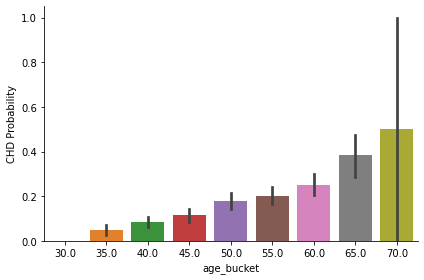

In [42]:
ax=sns.factorplot('age_bucket', 'TenYearCHD', kind='bar', data = train_df, size=4, aspect=1.5)
ax.set_ylabels('CHD Probability')

<b>The positive CHD cases seems to be more prevalent in older people.</b>

### <b>Cigarettes per Day</b>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


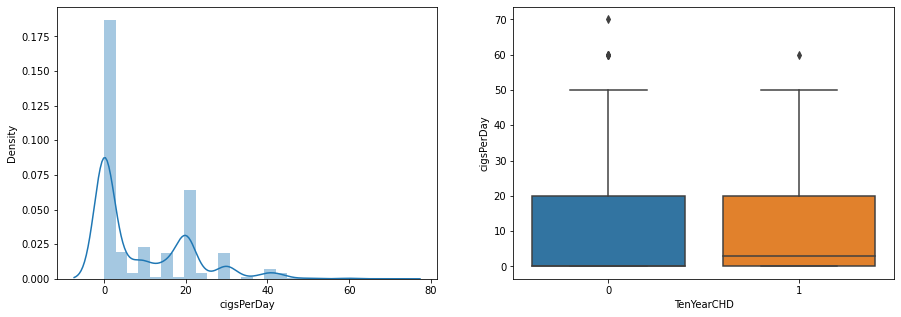

In [45]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.distplot(train_df['cigsPerDay'], ax=axes[0])
sns.boxplot(y='cigsPerDay',x='TenYearCHD',data=train_df, ax=axes[1])

In [46]:
cont_dependency('cigsPerDay')

significance=0.010, p=0.00184
Ten year Risk of CHD is dependent on the continuous variable


True

<b>We see that the median is slighlty higher for the positive cases, which means people who smoke higher number of cigarette per day, tend to show cardio-vascular disease</b>